In [1]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def parse_tfrecord(example_proto):
    """Parse TFRecord data and fix color inversion."""
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32)
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode JPEG image properly
    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)

    # Convert to float and normalize
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Fix color inversion (convert negative image back to normal)
    image = 1.0 - image  # This inverts the inverted image back to normal

    # Resize to model input size
    image = tf.image.resize(image, [224, 224])

    # Extract labels and bounding boxes
    labels = tf.sparse.to_dense(parsed_features['image/object/class/label'])
    labels = tf.cast(labels, tf.float32)

    xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'])

    boxes = tf.stack([ymin, xmin, ymax, xmax], axis=1)

    return image, {'classification': labels, 'regression': boxes}



def create_dataset(tfrecord_folder, batch_size=32):
    """Create dataset from a folder containing TFRecord files."""
    tfrecord_files = [os.path.join(tfrecord_folder, f) for f in os.listdir(tfrecord_folder)
                      if f.endswith('.tfrecord')]

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.padded_batch(
        batch_size,
        padded_shapes=(
            [224, 224, 3],
            {
                'classification': [None],
                'regression': [None, 4]
            }
        ),
        padding_values=(
            tf.constant(0.0),
            {
                'classification': tf.constant(0.0),
                'regression': tf.constant(0.0)
            }
        )
    )
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [3]:
def create_model():
    """Create a model with a MobileNetV2 base and custom head for binary classification and bounding box prediction."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)

    # Classification branch (binary classification)
    classification = layers.Dense(1, activation='sigmoid')(x)  # Single output with sigmoid for binary classification
    classification_output = layers.Reshape((-1, 1), name='classification')(classification)

    # Regression branch (bounding boxes)
    regression = layers.Dense(32, activation='relu')(x)
    regression = layers.Dense(16, activation='relu')(regression)
    regression = layers.Dense(4)(regression)
    regression_output = layers.Reshape((-1, 4), name='regression')(regression)

    model = models.Model(inputs=base_model.input, outputs=[classification_output, regression_output])
    return model

In [4]:
def data_augmentation(image, boxes):
    # Randomly flip the image and bounding boxes horizontally
    image, boxes = tf.image.flip_left_right(image), tf.image.flip_left_right(boxes)

    # Randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Randomly adjust contrast
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

    # Randomly adjust saturation
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Random rotation
    angle = tf.random.uniform([], minval=-0.1, maxval=0.1)
    image = tf.image.rotate(image, angle)
    return image, boxes

In [5]:
def focal_loss(gamma=2., alpha=0.25):
    """Focal Loss for binary classification task."""
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Compute the focal loss component
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

        return tf.reduce_mean(loss)

    return focal_loss_fixed


def smooth_l1_loss(y_true, y_pred):
    """Smooth L1 loss with masking for padded boxes."""
    # Create mask for valid boxes (non-zero in any coordinate)
    mask = tf.cast(tf.reduce_any(tf.not_equal(y_true, 0.0), axis=-1, keepdims=True), tf.float32)

    diff = tf.abs(y_true - y_pred)
    loss = tf.where(diff < 1.0, 0.5 * tf.square(diff), diff - 0.5)

    # Apply mask and compute mean
    return tf.reduce_sum(loss * mask) / tf.maximum(tf.reduce_sum(mask), 1.0)  # Avoid division by zero



def train_model(model, train_dataset, validation_dataset, epochs=10):
    """Train the model with custom loss functions."""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'classification': focal_loss(gamma=2.0, alpha=0.25),  # Classification branch
            'regression': smooth_l1_loss                          # Regression branch
        },
        loss_weights={
            'classification': 1.0,
            'regression': 1.0
        },
        metrics={'classification': 'accuracy'}
    )

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[tensorboard_callback],
        verbose=1
    )
    return history


def evaluate_model(model, test_dataset):
    """Evaluate the model on the test dataset."""
    results = model.evaluate(test_dataset, verbose=1)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]}")
    return results


def convert_to_tflite(model, output_path):
    """Convert model to TFLite format."""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open(output_path, 'wb') as f:
        f.write(tflite_model)

In [6]:
def visualize_predictions(model, dataset, num_images=5):
    """Visualize model predictions on a batch of images."""
    for batch in dataset.take(1):  # Take one batch from the dataset
        images, targets = batch
        # Get ground truth values
        true_labels = targets['classification']
        true_boxes = targets['regression']

        # Run the model on the batch
        predictions = model(images, training=False)
        predicted_labels = predictions[0]
        predicted_boxes = predictions[1]

        plt.figure(figsize=(15, 15))

        for i in range(num_images):
            img = images[i].numpy()
            true_box = true_boxes[i].numpy()
            pred_box = predicted_boxes[i].numpy()

            fig, ax = plt.subplots(1, figsize=(6, 6))
            ax.imshow(img)

            # Get image dimensions
            img_h, img_w, _ = img.shape

            # Draw ground truth bounding boxes
            for j in range(len(true_box)):
                ymin, xmin, ymax, xmax = true_box[j]
                rect = patches.Rectangle(
                    (xmin * img_w, ymin * img_h),  # Convert relative to pixel values
                    (xmax - xmin) * img_w,
                    (ymax - ymin) * img_h,
                    linewidth=2, edgecolor='green', facecolor='none', label="True box"
                )
                ax.add_patch(rect)

            # Draw predicted bounding boxes
            for j in range(len(pred_box)):
                ymin, xmin, ymax, xmax = pred_box[j]
                rect = patches.Rectangle(
                    (xmin * img_w, ymin * img_h),  # Convert relative to pixel values
                    (xmax - xmin) * img_w,
                    (ymax - ymin) * img_h,
                    linewidth=2, edgecolor='red', facecolor='none', label="Predicted box"
                )
                ax.add_patch(rect)

            plt.title(f"Prediction vs Ground Truth")
            plt.show()

In [7]:
BASE_PATH = "data"
TRAIN_FOLDER = os.path.join(BASE_PATH, "train")
TEST_FOLDER = os.path.join(BASE_PATH, "test")
VALID_FOLDER = os.path.join(BASE_PATH, "valid")

# Create datasets
train_dataset = create_dataset(TRAIN_FOLDER, batch_size=32)
val_dataset = create_dataset(VALID_FOLDER, batch_size=32)
test_dataset = create_dataset(TEST_FOLDER, batch_size=32)

In [8]:
# Create and train model
model = create_model()
history = train_model(model, train_dataset, val_dataset, epochs=10)

Epoch 1/10
     28/Unknown 23s 411ms/step - classification_accuracy: 0.6323 - classification_loss: 0.0114 - loss: 0.6082 - regression_loss: 0.5967

C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - classification_accuracy: 0.6333 - classification_loss: 0.0111 - loss: 0.5957 - regression_loss: 0.5840 - val_classification_accuracy: 0.7059 - val_classification_loss: 9.9584e-09 - val_loss: 0.0467 - val_regression_loss: 0.0359
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - classification_accuracy: 0.6779 - classification_loss: 6.8241e-09 - loss: 0.0464 - regression_loss: 0.0463 - val_classification_accuracy: 0.5176 - val_classification_loss: 3.3350e-09 - val_loss: 0.0491 - val_regression_loss: 0.0363
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step - classification_accuracy: 0.6063 - classification_loss: 4.1929e-09 - loss: 0.0412 - regression_loss: 0.0412 - val_classification_accuracy: 0.5176 - val_classification_loss: 3.5447e-09 - val_loss: 0.0449 - val_regression_loss: 0.0338
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - classification_accuracy: 0.6653 - classification_loss: 3.7695e-09 - loss: 0.0347 - regression_loss: 0.

In [9]:
# Evaluate model on test dataset
evaluate_model(model, test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - classification_accuracy: 0.5440 - classification_loss: 3.7261e-09 - loss: 0.0398 - regression_loss: 0.0379
Test Loss: 0.04325851425528526
Test Accuracy: 3.0820528351682697e-09


[0.04325851425528526,
 3.0820528351682697e-09,
 0.033775851130485535,
 0.5411764979362488]

<Figure size 1500x1500 with 0 Axes>

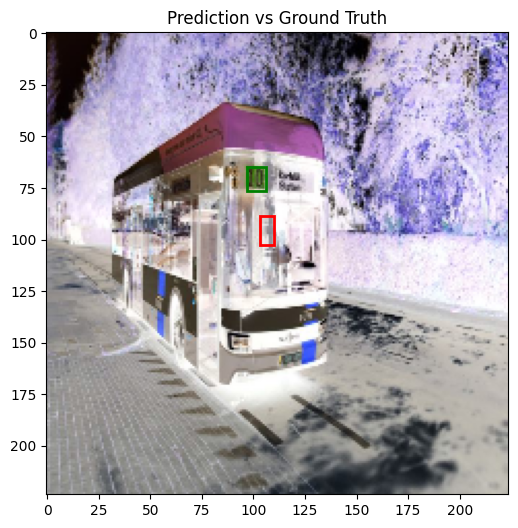

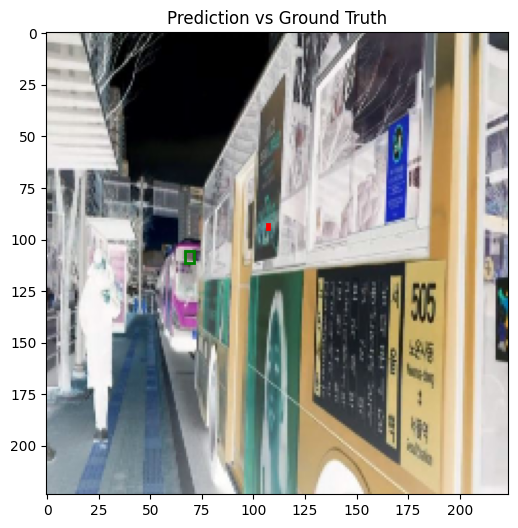

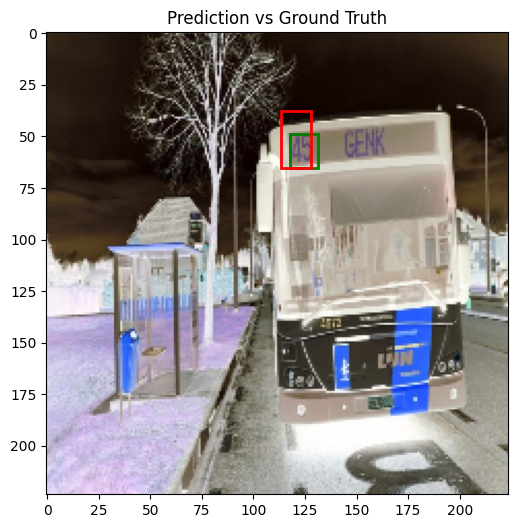

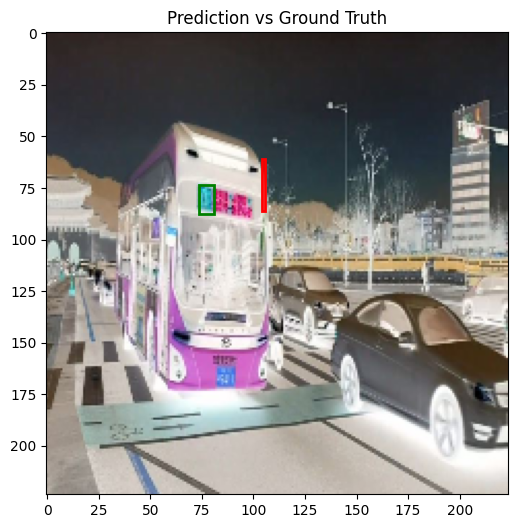

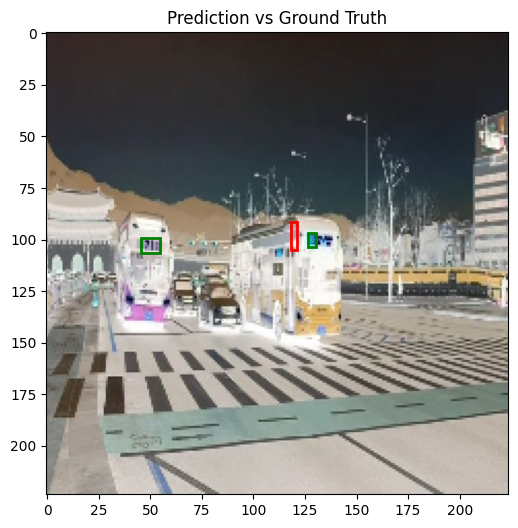

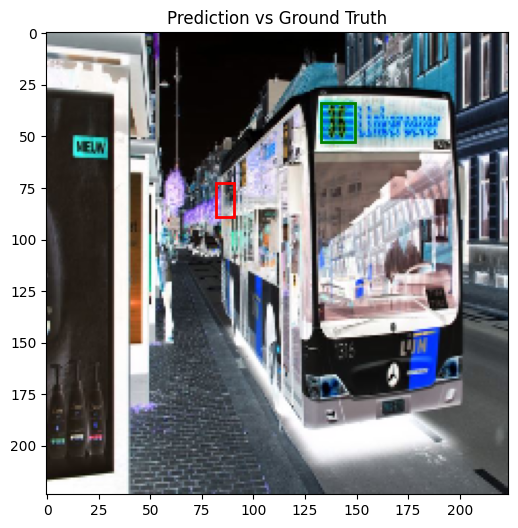

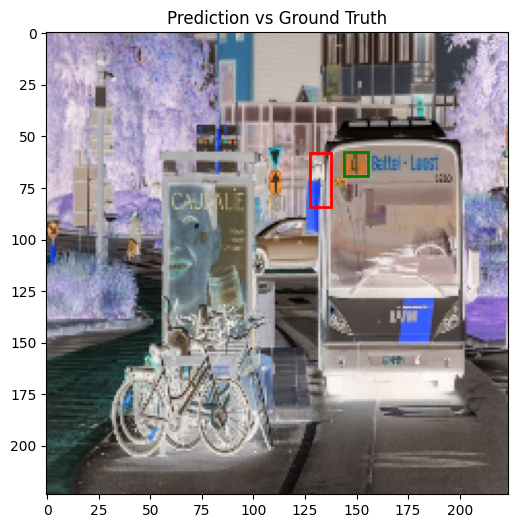

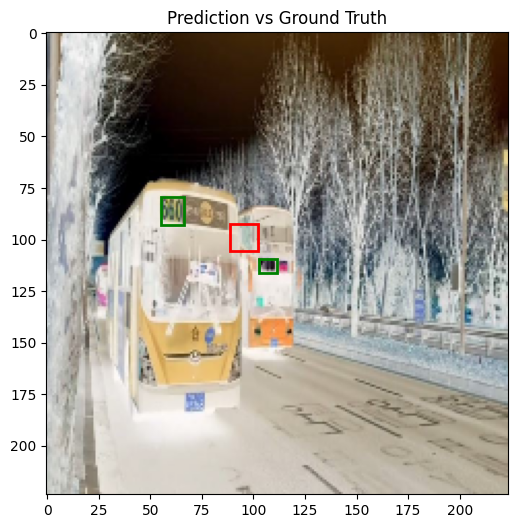

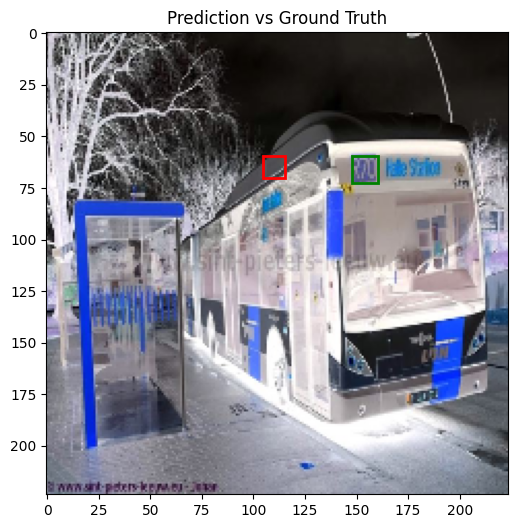

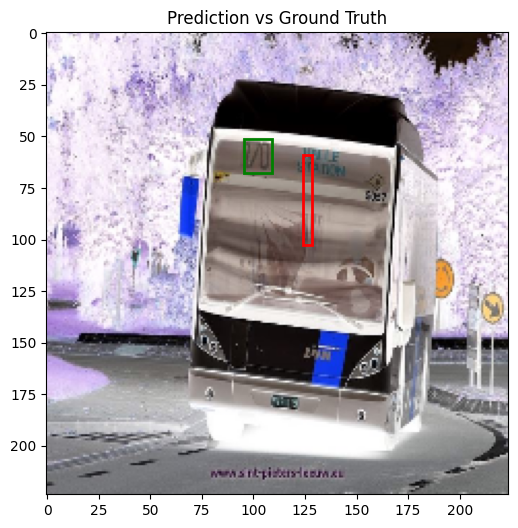

In [14]:
visualize_predictions(model, test_dataset, num_images=10)

In [11]:
# Convert to TFLite
convert_to_tflite(model, "bus_number_detector.tflite")

INFO:tensorflow:Assets written to: C:\Users\alpay\AppData\Local\Temp\tmpmads711r\assets


INFO:tensorflow:Assets written to: C:\Users\alpay\AppData\Local\Temp\tmpmads711r\assets


Saved artifact at 'C:\Users\alpay\AppData\Local\Temp\tmpmads711r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None)]
Captures:
  1841029310672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029310288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029312016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029311440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029310864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029310096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029309520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029311824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1841029312592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  184